# Visualizing NOAA satellite data from the cloud

This very short tutorial will show the basic steps to accessing GOES-16 data on AWS and make an image of the [Sandwich RGB](https://www.star.nesdis.noaa.gov/goes/documents/SandwichProduct.pdf)!

The main steps will be:
* Import relevant packages
* Search cloud repositories for the data we want
* Import the data into memory
* Make a plot of the sandwich product

If you have never coded in Python before, this will probably be fast but I can provide resources to more beginner friendly tools.

We will use three packages for this project:

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import s3fs

The package s3fs is file interface for Amazon S3 (Simple Storage Service) buckets, so you can browse and search for data. NOAA's Open Data Dissemination (NODD) program is increasing access to satellite data, including GOES and JPSS. In this tutiral, we'll look at [GOES-16 Mesoscale data in S3](https://registry.opendata.aws/noaa-goes).

First, we have to initialize the filesystem. We pass in the keyword anon because we are not going to pass any login information since the data are public.

In [2]:
fs = s3fs.S3FileSystem(anon=True)

You can manually browse the contents of the S3 bucket using the link above, or you can search in the command line. The S3 bucket is named 'noaa-goes16,' and using s3fs's ls command (we'll only print the first 5 entries for brevity):

In [3]:
fs.ls('noaa-goes16')[0:5]

['noaa-goes16/ABI-L1b-RadC',
 'noaa-goes16/ABI-L1b-RadF',
 'noaa-goes16/ABI-L1b-RadM',
 'noaa-goes16/ABI-L2-ACHAC',
 'noaa-goes16/ABI-L2-ACHAF']

We can repeat the search above by extending the argument from 'noaa-goes16' to 'noaa-goes16/ABI-L1b-RadM' and running the command again. To save some time, let's construct the full path below:

In [4]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadM'
year = 2022
doy = 285
hour = 20

path = bucket_name + '/' + product_name + '/' + str(year) + '/' + str(doy).zfill(3) + '/' + str(hour).zfill(2) + '/'
print(path)

noaa-goes16/ABI-L1b-RadM/2022/285/20/


Since we're looking at the mesosector scan, this search will still yield a lot of results:

In [5]:
files = fs.ls(path)
print(files[0:5])

['noaa-goes16/ABI-L1b-RadM/2022/285/20/OR_ABI-L1b-RadM1-M6C01_G16_s20222852000281_e20222852000339_c20222852000376.nc', 'noaa-goes16/ABI-L1b-RadM/2022/285/20/OR_ABI-L1b-RadM1-M6C01_G16_s20222852001252_e20222852001310_c20222852001346.nc', 'noaa-goes16/ABI-L1b-RadM/2022/285/20/OR_ABI-L1b-RadM1-M6C01_G16_s20222852002252_e20222852002310_c20222852002343.nc', 'noaa-goes16/ABI-L1b-RadM/2022/285/20/OR_ABI-L1b-RadM1-M6C01_G16_s20222852003252_e20222852003310_c20222852003353.nc', 'noaa-goes16/ABI-L1b-RadM/2022/285/20/OR_ABI-L1b-RadM1-M6C01_G16_s20222852004252_e20222852004310_c20222852004350.nc']


If you've seen satellite data files before, you'll know they have long filenames. Let's break it down:

\[sensor and product name\]-\[scan sector\]_\[satellite\]_s\[scan start time\]_e\[scan end time\]_c\[creation time\].nc

To save a little bit of time, let's cheat a bit and only work with the first available time stamp (s20222852000281). The sandwich product takes the difference of ABI channels 3 and 13. The snippet of code below will search all the files and only keep the ones that have 'C03' or 'C13' and the start time 's20222852000281'.

I'm using a list comprehension, which is a shorter way of writing a loop. For reference, the original loop is commented out:

In [6]:
# Long form of writing a loop
# for file in files:
#     if ('C01_G16_s20222852000281' in file) | ('C13_G16_s20222852000281'):
#         print(file)

matches = [file for file in files if ('C03_G16_s20222852000281' in file) | ('C13_G16_s20222852000281' in file)]
print(matches)

['noaa-goes16/ABI-L1b-RadM/2022/285/20/OR_ABI-L1b-RadM1-M6C03_G16_s20222852000281_e20222852000339_c20222852000373.nc', 'noaa-goes16/ABI-L1b-RadM/2022/285/20/OR_ABI-L1b-RadM1-M6C13_G16_s20222852000281_e20222852000350_c20222852000397.nc']


Now that we have found our files in the satellite data "haystack" we can finally open them:

In [7]:
remote_obj_ch3 = fs.open(matches[0], mode='rb')
remote_obj_ch13 = fs.open(matches[1], mode='rb')

We will need to use xarray to read/interpret the netCDF file.

In [8]:
abi_ch3 = xr.open_dataset(remote_obj_ch3, engine='h5netcdf')
abi_ch13 = xr.open_dataset(remote_obj_ch13, engine='h5netcdf')

We can print the header information to see the file contents:

In [9]:
abi_ch3


<xarray.Dataset>
Dimensions:                                           (y: 1000, x: 1000, number_of_time_bounds: 2, number_of_image_bounds: 2, band: 1, num_star_looks: 24)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.1137 ... ...
  * x                                                 (x) float32 -0.04871 .....
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds, band, num_star_looks
Data variables: (12/37)
    Rad                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    star_id                                           (num_star_looks) float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           RBU
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2022-10-12T20:00:37.3Z
    time_coverage_start:       2022-10-12T20:00:28.1Z
    time_coverage_end:         2022-10-12T20:00:33.9Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        c8061263-30d2-4d4b-ae5e-277405a61683

We can learn a lot about the file from the header. For example, the file dimensions are 1000 x 1000, there's a useful variable named Rad (for Radiance), and the x and y coordinates in the geostationary projection. Let's preview what the image will look like using matplotlib and imshow. You can use packages like cartopy to plot onto different map projections, but to keep today's tutorial short we'll just look at the raw image.

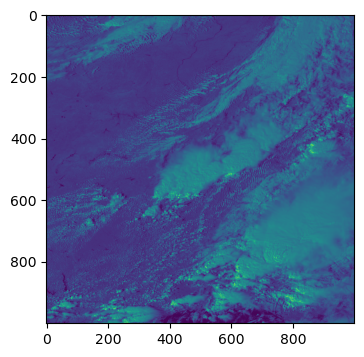

In [10]:
plt.figure(figsize=[4,4])
plt.imshow(abi_ch3.Rad)
plt.show()

Our goal is to create a sandwich product, which combines ABI channel 3 and channel 13 radiances. First, let's extract the radiances from the file:

In [11]:
C13 = abi_ch13.Rad.values
C03 = abi_ch3.Rad.values

We need to make sure both are the same resolution, but unfortunately they are not. Channel 3 is 1 km and Channel 13 is 2 km. You can use the shape command to check the array size:

In [12]:
C13.shape, C03.shape

((500, 500), (1000, 1000))

There are many techniques to change the data reoslution, but a fast and simple way to change the gridding to skip every other pixel. Python can skip indices using the double colons (::) followed by an integer. We'll overwrite the original variable with this new smaller resolution variable.

In [13]:
C03 = C03[::2, ::2]
C03.shape, abi_ch13.Rad.shape

((500, 500), (500, 500))

Now that the data are the same shape, we can difference them to create the sandwich product:

In [14]:
sandwich = C03 - C13

Finally, we'll make a plot of our hard work!

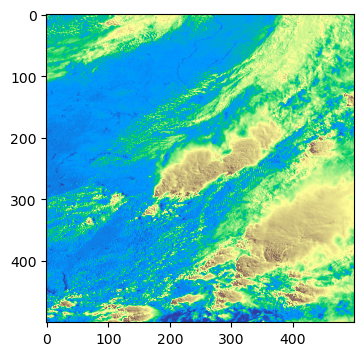

In [15]:
plt.figure(figsize=[4,4])
plt.imshow(sandwich, cmap=plt.get_cmap("terrain"))
plt.show()

# Summary
Through this tutorial, we can see first hand how easy it is to access data from AWS. NOAA is adding more datasets to AWS. JPSS will initially add sounding data from CrIS and ATMS in addition to other products. One caveat is that AWS data is not guaranteed to be operational. However, it is an excellent point of data access for retrospective analysis.